In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
import tensorflow as tf
from keras import optimizers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard,CSVLogger

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)



In [38]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [39]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/input_data.csv', sep='\t', encoding='utf-8', index_col=0)


In [40]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(229716, 2) (229716,)


In [41]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y


In [42]:
# Temporalize the data
lookback = 20
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)



In [43]:
#Split into Test, valid and train

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [44]:
# Reshape the arrays

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
# X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
# X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
# X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
# X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)b
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [45]:
y_train.shape

(147004,)

In [46]:
## To Categorical Data

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_valid = to_categorical(y_valid)

# print(y_valid.shape, y_test.shape, y_train.shape)

In [47]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
print(n_timesteps,n_features,n_outputs)

20 2 1


In [48]:
X_train_y0 = X_train[y_train==0.]
X_train_y1 = X_train[y_train==1.]

X_valid_y0 = X_valid[y_valid==0.]
X_valid_y1 = X_valid[y_valid==1.]

In [49]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

### Stardarization

In [50]:
# Initialize a scaler using the training data.
# scaler = StandardScaler().fit(flatten(X_train))

In [51]:
# Standarize the input

# X_train_scaled = scale(X_train, scaler)
# X_valid_scaled = scale(X_valid, scaler)
# X_test_scaled = scale(X_test, scaler)

### Test Standarization

In [52]:
# a = flatten(X_train_scaled)
# print('colwise mean', np.mean(a,axis=0).round(6))
# print('colwise variance', np.var(a, axis=0))



# Model training

Training models (Use it)



In [53]:
lr = 0.0001
verbose, epochs, batch_size = 1, 100, 64

In [54]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(n_timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 20, 32)            4480      
_________________________________________________________________
lstm_14 (LSTM)               (None, 16)                3136      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 20, 16)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 20, 16)            2112      
_________________________________________________________________
lstm_16 (LSTM)               (None, 20, 32)            6272      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 2)             66        
Total params: 16,066
Trainable params: 16,066
Non-trainable params: 0
_________________________________________________________________


In [55]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam, , metrics=['accuracy'])

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0, X_train_y0, 
                                                epochs=epochs, 
                                                batch_size=batch_size, 
                                                callbacks=[early_stopping_monitor],
                                                validation_data=(X_valid_y0, X_valid_y0),
                                                verbose=verbose)

Train on 140681 samples, validate on 35142 samples
Epoch 1/100
140681/140681 [==============================] - 405s 3ms/step - loss: 9481.3311 - val_loss: 6998.4015
Epoch 2/100
140681/140681 [==============================] - 403s 3ms/step - loss: 4939.5315 - val_loss: 3805.4630
Epoch 3/100
140681/140681 [==============================] - 398s 3ms/step - loss: 4159.7623 - val_loss: 4178.1937
Epoch 4/100
140681/140681 [==============================] - 402s 3ms/step - loss: 3853.8902 - val_loss: 3621.9555
Epoch 5/100
140681/140681 [==============================] - 401s 3ms/step - loss: 3462.9016 - val_loss: 3259.4536
Epoch 6/100
140681/140681 [==============================] - 403s 3ms/step - loss: 3176.0674 - val_loss: 3257.3941
Epoch 7/100
140681/140681 [==============================] - 395s 3ms/step - loss: 3284.1705 - val_loss: 3209.3413
Epoch 8/100
140681/140681 [==============================] - 394s 3ms/step - loss: 3444.2922 - val_loss: 3726.1809
Epoch 9/100
140681/140681 [==

dict_keys(['val_loss', 'loss'])


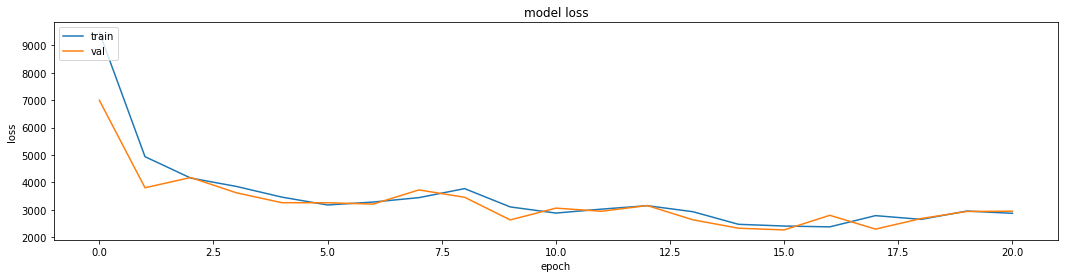

In [71]:
# list all data in history
print(lstm_autoencoder_history.history.keys())

# # summarize history for accuracy
# plt.plot(lstm_autoencoder_history.history['acc'])
# plt.plot(lstm_autoencoder_history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')

# # Get current size
# fig_size = plt.rcParams["figure.figsize"]
# #  Set figure width to 18 and height to 4
# fig_size[0] = 18
# fig_size[1] = 4
# plt.rcParams["figure.figsize"] = fig_size

# plt.savefig('/home/francovm/Projects/SSE/data/Visualization/LSTM-20days-acc-Autoencoder.png')
# plt.show()

# summarize history for loss
plt.plot(lstm_autoencoder_history.history['loss'])
plt.plot(lstm_autoencoder_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
 # Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.savefig('/home/francovm/Projects/SSE/data/Visualization/LSTM-20days-loss-Autoencoder.png')
plt.show()

# Save Model

In [85]:
# save model and architecture to single file

# lstm_autoencoder.save("/home/francovm/Projects/SSE/models/Autoencoder/LSTM_SSE_20days-Classification.h5")

# df = pd.DataFrame(lstm_autoencoder_history.history)

# df.to_csv( '/home/francovm/Projects/SSE/data/Visualization/Data/LSTM_SSE_20days_Autoencoder_Classification.csv',header=True)


# Sanity check

Doing a sanity check by validating the reconstruction error on the train data. Here we will reconstruct the entire train data with both 0 and 1 labels.

**Expectation**: the reconstruction error of 0 labeled data should be smaller than 1.

**Caution**: do not use this result for model evaluation. It may result into overfitting issues.

IndexError: tuple index out of range

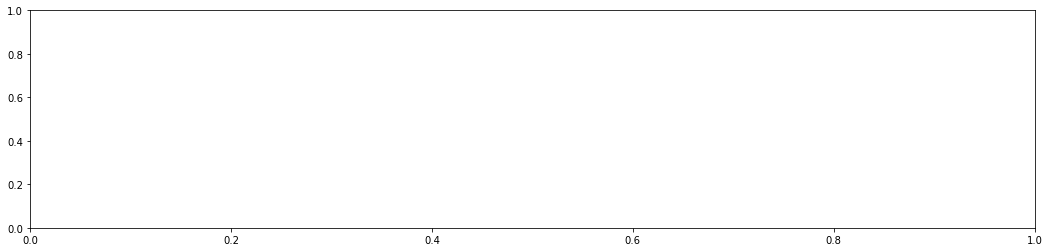

In [95]:
# train_x_predictions = lstm_autoencoder.predict(X_train)
mse = np.mean(np.power(flatten(X_train) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',label= "Break" if name == 1. else "Normal")

ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Predictions using the Autoencoder

In [ ]:
valid_x_predictions = lstm_autoencoder.predict(X_valid)
mse = np.mean(np.power(flatten(X_valid) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
test_x_predictions = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(flatten(X_test) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3 # Definir!
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

In [ ]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()